In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils import shuffle 
import regex 
%pip install emoji
import emoji
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random 
import time 
import torch
import torch.nn.functional as F
%pip install transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, BertConfig
from sentence_transformers import SentenceTransformer
from torch.utils.data import TensorDataset, random_split, DataLoader, SequentialSampler, RandomSampler
from transformers import get_linear_schedule_with_warmup
RANDOM_STATE = 256


torch.cuda.is_available()
cuda = torch.device('cuda')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234912 sha256=b06d0d076120b1742e2c85f8769e56ba0979c4d2eb2c1923ea619b6078d28ea4
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [41]:
def preprocess(path):
    
    """
    
    preprocess: takes path to single tweets.csv and cleans it
    
    params:
    
    - path: path to .csv file
    
    returns: 
    - x: cleaned data 
    - y: labels 
    
    use: only use on original train/val csv from kaggle 
    
    """ 

    dat = pd.read_csv(path)
    add_row = dat.columns.to_numpy()
    dat.loc[len(dat.index)] = add_row
    dat.columns = ["Index", "Source", "Sentiment", "Tweet"]

    x = pd.DataFrame(dat["Tweet"])
    y = pd.DataFrame(dat["Sentiment"])

    y.drop(dat[dat.isnull().any(axis=1)].index.to_numpy(), inplace=True)
    y.reset_index(inplace=True)
    y.drop("index", axis=1, inplace=True)
    x.drop(dat[dat.isnull().any(axis=1)].index.to_numpy(), inplace=True)
    x.reset_index(inplace=True)
    x.drop("index", axis=1, inplace=True)
    
    my_dict = {'positive':0, 'negative':1, 'neutral':2,'irrelevant':3}
    

    y = y.to_numpy()
    y[y == 'Positive'] = 0 
    y[y == 'Negative'] = 1
    y[y == 'Neutral'] = 2
    y[y == 'Irrelevant'] = 3
    x = x.to_numpy()



    x = x.flatten()
    y = y.astype(int).flatten()

    return (x, y)


def train_val_test(x, y, first_split=0.40, second_split=0.50, seed=256):
    
    """
    train_val_test: sped up function for train/test/splitting of cleaned .npy data 
    
    params: 
    - x: cleaned tweet.npy 
    - y: cleaned label.npy 
    - first_split: test split proportion for first split (train/unprocessed) 
    - second_split: test split proportion for second split of unprocessed (val/test)
    - seed: random seed for splitting 
    
    returns: 
    - dict of train/val/tst sets 
    
    """ 
    np.random.seed(seed)
    x_tr, x_mid, y_tr, y_mid = train_test_split(
        x, y, test_size=first_split, random_state=seed
    )
    x_val, x_tst, y_val, y_tst = train_test_split(
        x_mid, y_mid, test_size=second_split, random_state=seed
    )

    return {
        "x_tr": x_tr,
        "y_tr": y_tr,
        "x_val": x_val,
        "y_val": y_val,
        "x_tst": x_tst,
        "y_tst": y_tst,
    }


def to_loader(output, batch_size=32, type="tr"):
    
    """ 
    to_loader: 
    - compiles tokenized data into tensor datasets
    - turns tensor datasets into torch data loaders of specified batch_size
    
    params: 
    - output: len(3) tuple resulting from @tokenize function or regular (dat,lab) tuple  
    - batch_size: batch size for dataloaders 
    - type: must be in ['tr', 'val', 'tst'] 
        -- determines what type of random sampler to use 
        
    returns: 
    - dataloader: torch dataloader  
    
    """
    
    if len(output) == 3: 
    
        dat = TensorDataset(output[0], output[1], output[2])
        
        if type == "tr":
            dataloader = DataLoader(dat, sampler=RandomSampler(dat), batch_size=batch_size)
            return dataloader
        
        elif type in ["val", "tst"]:
            dataloader = DataLoader(
                dat, sampler=SequentialSampler(dat), batch_size=batch_size
            )
            
            return dataloader
        
    elif len(output) == 2: 
        
        dat = TensorDataset(output[0], output[1])
        
        if type == "tr":
            dataloader = DataLoader(dat, sampler=RandomSampler(dat), batch_size=batch_size)
            return dataloader
        
        elif type in ["val", "tst"]:
            dataloader = DataLoader(
                dat, sampler=SequentialSampler(dat), batch_size=batch_size
            )
            return dataloader
    

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text)

    return emoji_list + flags


def get_emoji(x): 
    emoji_list = [] 
    for i in range(0, len(x)): 
        text = x[i]
        emojis = split_count(text) 
        if len(emojis) > 0: 
            emoj_list.append(list(set(emojis)))
    emoj_flat = [item for sublist in emoj_list for item in sublist]

    return emoj_flat


def tokenize(x, y, tokenizer, emoji = False):

        """ 
        tokenize: takes in .numpy data and tokenizes using BertTokenizer 

        params: 
        - x: ,npy tweets
        - y: .npy labels 

        returns: 
        - input_ids: id tokens 
        - attention_masks: masks 
        - labels: labels 

        """

        if emoji is False: 

            input_ids = []
            attention_masks = []
            for sentence in x:
                encoded_dict = tokenizer.encode_plus(
                    sentence,
                    add_special_tokens=True,
                    max_length=64,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors="pt",
                    truncation=True,
                )
                input_ids.append(encoded_dict["input_ids"])
                attention_masks.append(encoded_dict["attention_mask"])
            input_ids = torch.cat(input_ids, dim=0).cuda()
            attention_masks = torch.cat(attention_masks, dim=0).cuda()
            labels = torch.tensor(y).type(torch.LongTensor).cuda()

            return (input_ids, attention_masks, labels)

        else: 

            emojis = get_emoji(x) 
            tokenizer.add_tokens(emojis)

            input_ids = []
            attention_masks = []
            for sentence in x:
                encoded_dict = tokenizer.encode_plus(
                    sentence,
                    add_special_tokens=True,
                    max_length=64,
                    pad_to_max_length=True,
                    return_attention_mask=True,
                    return_tensors="pt",
                    truncation=True,
                )
                input_ids.append(encoded_dict["input_ids"])
                attention_masks.append(encoded_dict["attention_mask"])
            input_ids = torch.cat(input_ids, dim=0).cuda()
            attention_masks = torch.cat(attention_masks, dim=0).cuda()
            labels = torch.tensor(y).type(torch.LongTensor).cuda()

            return (input_ids, attention_masks, labels)


def data_pipe(X, Y, tokenizer, first_split=0.40, second_split=0.50, seed=256, batch_size=32, emoji = False):
    
    """ 
    data_pipe: splits, tokenizes, and returns data in dataloaders 
    
    params: 
    - X: tweet.npy 
    - Y: label.npy 
    - first_split: see @train_val_test 
    - second_split: see @train_val_test 
    - seed: see @train_val_test 
    - batch_size: see @to_loader
    
    returns: 
    - train_loader: loader for train dat 
    - val_loader: loader for val dat 
    - tst_loader: loader for tst dat
    
    """
    
    splits = train_val_test(X, Y, first_split, second_split, seed)
    tokenizer = tokenizer 
    train_token = tokenize(splits["x_tr"], splits["y_tr"], tokenizer, emoji)
    val_token = tokenize(splits["x_val"], splits["y_val"], tokenizer, emoji)
    tst_token = tokenize(splits["x_tst"], splits["y_tst"], tokenizer, emoji)

    train_loader = to_loader(train_token, batch_size, type = "tr")
    val_loader = to_loader(val_token, batch_size, type = "val")
    tst_loader = to_loader(tst_token, batch_size, type = "tst")

    return (train_loader, val_loader, tst_loader)



def flat_accuracy(preds, labels):
    
    """ 
    
    flat_accuracy: computes accuracy between preds and labels 
    
    params: 
    - preds: predictions
    - labels: labels 
    
    returns: 
    - accuracy
    
    """
    
    pred_flat = np.argmax(preds.numpy(), axis=1).flatten()
    labels_flat = labels.numpy().flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def f1_score_func(preds, labels):
    
    """ 
    f1_score_func: computes weighted f1 between preds and labels 
    
    params: 
    - preds: predictions
    - labels: labels 
    
    returns: 
    - weighted f1
    
    """
    
    preds_flat = np.argmax(preds.numpy(), axis=1).flatten()
    labels_flat = labels.numpy().flatten()
    return f1_score(labels_flat, preds_flat, average="weighted")

def finetune(path, model, train_loader, val_loader, tokenizer_length = None,  epochs=5, tolerance=0.01, patience = 2, emoji = False):
    
    """ 
    
    finetune: finetunes pretrained BertForSequenceClassification model on tweet data 
    
    params: 
    - path: path to store best model 
    - model: BertForSequenceClassificationModel 
    - train_loader: torch loader for train dat 
    - val_loader: torch loader for val dat 
    - epochs: number of times to iterate through data 
    - tolerance: decides how close a lower validation loss can be to a previous best 
    - patience: decides how long loss can be lower than previous best before function exits 
    
    returns: 
    - training_stats: dictionary of accuracy, f1, val loss, and training loss over epochs 
    
    """
    
    model = model
    
    if emoji: 
        
        model.resize_token_embeddings(tokenizer_length)
        

    train_loader = train_loader
    val_loader = val_loader

    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    seed_val = 256
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

    training_stats = {"acc": [], "f1": [], "val_loss": [], 'training_loss': []}
    val_loss_tracker = 2e5
    tolerance = tolerance

    for epoch_i in range(0, epochs):
        print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_loader):
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            model.zero_grad()
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = outputs.loss.cuda()
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        training_stats['training_loss'].append(avg_train_loss)
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        # evaluation
        model.eval()
        total_eval_accuracy = 0
        total_eval_f1 = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        for batch in val_loader:
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )
                loss = outputs.loss.cuda()
                logits = outputs.logits.cuda()

            total_eval_loss += loss.item()
            total_eval_f1 += f1_score_func(logits.cpu(), b_labels.cpu())
            total_eval_accuracy += flat_accuracy(logits.cpu(), b_labels.cpu())

        avg_val_accuracy = total_eval_accuracy / len(val_loader)
        avg_val_f1 = total_eval_f1 / len(val_loader)
        avg_val_loss = total_eval_loss / len(val_loader)
        training_stats["acc"].append(avg_val_accuracy)
        training_stats["f1"].append(avg_val_f1)
        training_stats["val_loss"].append(avg_val_loss)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        print("  F1: {0:.2f}".format(avg_val_f1))
        print("  Loss: {0:.2f}".format(avg_val_loss))
        if avg_val_loss < val_loss_tracker - tolerance:
            val_loss_tracker = avg_val_loss
            torch.save(model.state_dict(), path + "best_model.pth")
        elif avg_val_loss > val_loss_tracker + tolerance:
            print("Exiting. Current loss is worst that previous.")
            break
            
    return training_stats


def get_embeddings(model, loader): 

    """ 
    
    get_embeddings: 
    
    - (1) Uses BertModelForSequenceClassification with finetuned state_dict loaded 
                    to generate hidden state embeddings for sentences
    - (2) Uses BertModel with Finetuned state_dict loaded to generate pooled cls token embedding for sentences
    
    params: 
    - model: BertModel with Finetuned state_dict loaded or BertModelForSequenceClassification with finetuned state_dict
    - loader: desired data to generate embeddings for 
    
    returns: 
    - embeddings: pooled cls token sentence embeddings or hidden state sentence embeddings
    - labels: labels 
    
    see @BertModel https://huggingface.co/docs/transformers/v4.24.0/en/model_doc/bert#transformers.BertModel
    
    
    """
    
    embedding_list = []
    label_list = []
    model.eval()
    
    if isinstance(model, BertForSequenceClassification): 


        for step, batch in enumerate(loader):
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    output_hidden_states=True,
                )
                hidden = outputs.hidden_states
                embedding = hidden[-1][:, 0, :]
                embedding_list.append(embedding.cpu())
                label_list.append(b_labels.cpu())

        embeddings = torch.cat(embedding_list, dim=0)
        labels = torch.cat(label_list, dim=0)
        
        return (embeddings, labels)

    
    else:  

        for step, batch in enumerate(loader):
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].cuda()
            b_labels = batch[2].cuda()
            with torch.no_grad():
                outputs = new_mod(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                )
                embedding_list.append(outputs.pooler_output.cpu())
                label_list.append(b_labels.cpu())

        embeddings = torch.cat(embedding_list, dim=0)
        labels = torch.cat(label_list, dim=0)

        return (embeddings, labels)
    
def test_on_batch(model, loader): 
    
    total_eval_f1 = 0
    total_eval_acc = 0
    
    for batch in loader:
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].cuda()
        b_labels = batch[2].cuda()

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            logits = outputs.logits.cuda()

        total_eval_f1 += f1_score_func(logits.cpu(), b_labels.cpu())
        total_eval_acc += flat_accuracy(logits.cpu(), b_labels.cpu())
        
    avg_f1 = total_eval_f1/len(loader)
    avg_acc = total_eval_acc/len(loader)
    
    
    return (avg_f1, avg_acc)


def plot_tune_loss(stats_dict, title, y_lim = [0.1,1]): 
    
    """
    
    plot_tune_loss: plots the stats_dict returned from @finetune 
    
    params: 
    - stats_dict: return from @finetune 
    - y_lim: y_limits on graph 
    
    returns: 
    - fig: the plot 
    
    """
    avg_val_loss = stats_dict['val_loss']
    avg_acc = stats_dict['acc']
    avg_f1 = stats_dict['f1']
    avg_train_loss = stats_dict['training_loss']
    epoch_list = range(1, len(avg_val_loss)+1)
    
    %matplotlib inline
    fig = figure(figsize=(15, 15), dpi=800)

    plt.rcParams.update({"font.size": 22})
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("%")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5
    
    plt.plot(
    list(epoch_list),
    list(avg_f1),
    linewidth=lw,
    alpha=0.2,
    color= 'darkgreen',
    label= "F1 Score",
    marker="o",
    )

    plt.plot(
        list(epoch_list),
        list(avg_acc),
        linewidth=lw,
        alpha=0.2,
        color= 'darkblue',
        label= "Accuracy",
        marker="o",
        )

    plt.plot(
        list(epoch_list),
        list(avg_val_loss),
        linewidth=lw,
        alpha=0.2,
        color= 'darkred',
        label= "Validation Loss",
        marker="o",
        )
    
    plt.plot(
        list(epoch_list),
        list(avg_train_loss),
        linewidth=lw,
        alpha=0.2,
        color= 'purple',
        label= "Training Loss",
        marker="o",
        )
    
    plt.legend()
    plt.grid()
    
    return fig

def plot_knn(metric_distances, y_lim = [0.1, 1]):
    
    """
    
    plot_knn: plots the metric dictionary returned from @finetune 
    
    params: 
    - metric_distances: metric dictionary generated by knn gridsearch
    - y_lim: y_limits on graph 
    
    returns: 
    - fig: the plot 
    
    """
    
    %matplotlib inline

    fig = figure(figsize=(15, 15), dpi=800)
    plt.rcParams.update({"font.size": 22})
    
    if isinstance(metric_distances, dict): 
    
        plt.title("Hidden State Features. Across KNN Distance Metrics and NNeighbors")
        plt.xlabel("Neighbors")
        plt.ylabel("F1")
        plt.ylim(y_lim[0], y_lim[1])
        lw = 5

        colors = {'euclidean': 'darkred', 'cityblock': 'darkblue', 'cosine':'darkgreen', 'correlation':'purple'}
        for j in ["euclidean", "cityblock", "cosine", "correlation"]:
            plt.plot(
            list(range(1,len(metric_distances[j])+1)),
            list(metric_distances[j]),
            linewidth=lw,
            alpha=0.2,
            color= colors[j],
            label= j,
            marker="o",
            )


        plt.legend()
        plt.grid()

        return fig 
    
    if isinstance(metric_distances, list): 
        
        plt.title("Sentence Transformer Features Across KNN NNeighbors")
        plt.xlabel("Neighbors")
        plt.ylabel("F1")
        plt.ylim(y_lim[0], y_lim[1])
        lw = 5
        plt.plot(
            list(range(1,len(metric_distances)+1)),
            metric_distances, 
            linewidth = lw, 
            alpha = 0.2,
            color = "darkgreen",
            label = "F1",
            marker = "o"
        )
        plt.legend()
        plt.grid()
        
        return fig 
        

def plot_svc(score_dict, y_lim = [0.1, 0.9], c = 2, c_range = range(-5,5)): 
    %matplotlib inline

    fig = figure(figsize=(15, 15), dpi=800)

    plt.rcParams.update({"font.size": 22})
    plt.title("Hidden State Features. Across SVM Kernel and Regularization")
    plt.xlabel("C (Base " + str(c) + ")")
    plt.ylabel("F1")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5

    colors = {'poly': 'darkred', 'rbf': 'darkblue', 'sigmoid':'darkgreen', 'linear':'purple'}
    for j in ["poly", "rbf", "sigmoid", "linear"]:
        plt.plot(
        list(c_range),
        list(score_dict[j]),
        linewidth=lw,
        alpha=0.2,
        color= colors[j],
        label= j,
        marker="o",
        )


    plt.legend()
    plt.grid()
            
    return fig 

def plot_adaboost(scores, y_lim = [0.1, 0.9], depth = range(10,15)): 
    %matplotlib inline
    
    fig = figure(figsize = (15,15), dpi = 800) 
    
    plt.rcParams.update({"font.size": 22})
    plt.title("ADA-BOOST F1 by Depth")
    plt.xlabel("Depth")
    plt.ylabel("%")
    plt.ylim(y_lim[0], y_lim[1])
    lw = 5
    plt.plot(
        list(depth),
        list(scores),
        linewidth=lw,
        alpha=0.2,
        color="darkred",
        label="ADA F1",
        marker="o",
    )


    plt.legend()
    plt.grid()
    
    return fig 

In [35]:
(og_tr_dat, og_tr_lab) = preprocess('./data/twitter_training.csv')
(og_tst_dat, og_tst_lab) = preprocess('./data/twitter_validation.csv')
og_tr_dat, og_val_dat, og_tr_lab, og_val_lab = train_test_split(og_tr_dat, og_tr_lab, test_size = 0.1, random_state = 256)
(len(og_tr_dat), len(og_val_dat), len(og_tst_dat))

(66596, 7400, 1000)

In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
og_tr_load = to_loader(tokenize(og_tr_dat, og_tr_lab.astype(int), tokenizer), type = 'tr')
og_val_load = to_loader(tokenize(og_val_dat, og_val_lab.astype(int), tokenizer), type = 'val')
og_tst_load = to_loader(tokenize(og_tst_dat, og_tst_lab.astype(int), tokenizer), type = 'tst')

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [39]:
og_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False,
)

og_model.cuda()
training_stats = finetune("./og_dict/", og_model, og_tr_load, og_val_load, epochs=10)

## PLOT FINETUNE STATS

fine_plot = plot_tune_loss(training_stats, title = "FineTunedBert on Original Split")
fine_plot.savefig('og_finetune.jpg', bbox_inches='tight')

## PREDICT ON BATCHES WITH SEQUENCE CLASSIFIER MODEL

total_eval_f1 = 0
total_eval_acc = 0

(av_f1, av_acc) = test_on_batch(og_model, og_tst_load)

print(av_f1) #89.9994
print(av_acc) #89.9989

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 10 ========
  Average training loss: 0.83
  Accuracy: 0.80
  F1: 0.80
  Loss: 0.55
======== Epoch 2 / 10 ========
  Average training loss: 0.36
  Accuracy: 0.89
  F1: 0.89
  Loss: 0.32
======== Epoch 3 / 10 ========
  Average training loss: 0.17
  Accuracy: 0.91
  F1: 0.91
  Loss: 0.29
======== Epoch 4 / 10 ========
  Average training loss: 0.12
  Accuracy: 0.93
  F1: 0.93
  Loss: 0.29
======== Epoch 5 / 10 ========
  Average training loss: 0.09
  Accuracy: 0.93
  F1: 0.93
  Loss: 0.30
Exiting. Current loss is worst that previous.
0.9619193124966333
0.9619140625


In [44]:
fine_plot = plot_tune_loss(training_stats, title = "FineTunedBert on Original Split")
fine_plot.savefig('og_finetune.jpg', bbox_inches='tight')

In [3]:
#LOAD DATA 

dat = np.load('data/tweets.npy', allow_pickle = True)
labs = np.load('data/labels.npy', allow_pickle = True)

#INITIALIZE TOKENIZER 

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

#PROCESS DATA AND CREATE DATALOADERS

(train_load, val_load, tst_load) = data_pipe(dat, labs, tokenizer)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


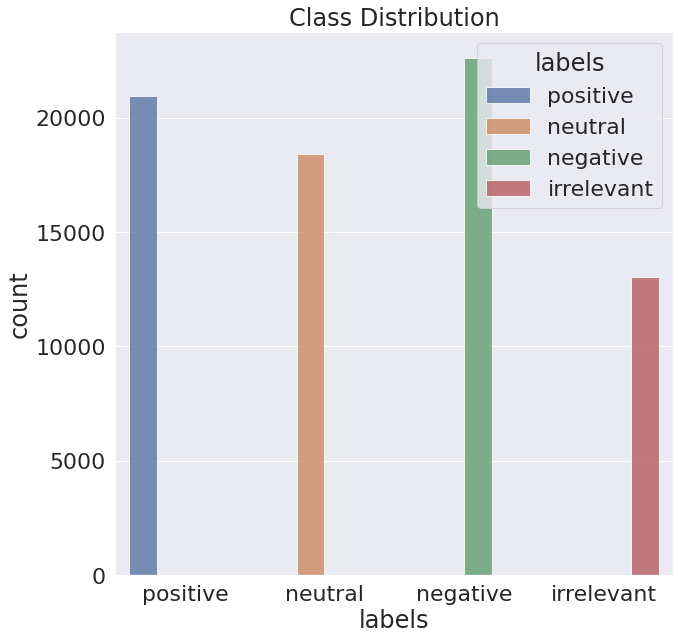

In [35]:
#GET DISTRIBUTION

label_dict = {0:'positive', 1:'negative', 2:'neutral', 3:'irrelevant'}
lab_df = pd.DataFrame({'labels':labs})
lab_df['labels'] = lab_df['labels'].map(label_dict)

import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style="darkgrid", font_scale = 2)
countplot = sns.countplot(x=lab_df["labels"], hue = lab_df['labels'], alpha = 0.8).set_title("Class Distribution")
fig = countplot.get_figure()
fig.savefig('countplot.jpg', dpi = 800)

In [4]:
# PREDICT WITHOUT FINETUNING 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()
(av_f1, av_ac) = test_on_batch(model, tst_load)

(av_f1, av_ac) #0.149, 0.300

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
#----- BEGINNING FINETUNING -------#

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False,
)

model.cuda()
training_stats = finetune("./stats_dict/", model, train_load, val_load, epochs=10)

## PLOT FINETUNE STATS

fine_plot = plot_tune_loss(training_stats)
fine_plot.savefig('finetune.jpg', bbox_inches='tight')

## PREDICT ON BATCHES WITH SEQUENCE CLASSIFIER MODEL

total_eval_f1 = 0
total_eval_acc = 0

(av_f1, av_acc) = test_on_batch(model, tst_load)

print(av_f1) #89.9994
print(av_acc) #89.9989

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

======== Epoch 1 / 10 ========
  Average training loss: 0.91
  Accuracy: 0.75
  F1: 0.74
  Loss: 0.67
======== Epoch 2 / 10 ========
  Average training loss: 0.47
  Accuracy: 0.84
  F1: 0.84
  Loss: 0.44
======== Epoch 3 / 10 ========
  Average training loss: 0.24
  Accuracy: 0.87
  F1: 0.87
  Loss: 0.40
======== Epoch 4 / 10 ========
  Average training loss: 0.14
  Accuracy: 0.89
  F1: 0.89
  Loss: 0.40
======== Epoch 5 / 10 ========
  Average training loss: 0.10
  Accuracy: 0.90
  F1: 0.90
  Loss: 0.45
Exiting. Current loss is worst that previous.
0.8999490213823009
0.8998978322672352


In [4]:
# ------ GET EMBEDDINGS -------- #

try:
    model
except NameError:
    var_exists = False
else:
    var_exists = True

if not var_exists: 
    
    model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    output_attentions=False,
    output_hidden_states=False,
    )
    
    model.cuda()


model.load_state_dict(torch.load("./state_dict/best_model.pth"))

embedding_dict = {}

for name, load in list(zip(['train', 'val', 'tst'], [train_load, val_load, tst_load])): 
    
    (embeddings, labels) = get_embeddings(model, load)
    
    embeddings = embeddings.numpy()
    labels = labels.numpy()
    
    embedding_dict[name] = (embeddings, labels)

train = embedding_dict['train']
val = embedding_dict['val'] 
tst = embedding_dict['tst']
    
    
# OR USE BELOW FOR POOLED EMBEDDINGS #

# config = model.bert.config
# new_mod = BertModel(config)
# new_mod.load_state_dict(model.bert.state_dict()).cuda()

# embedding_dict = {}

# for load in [train_lod, val_load, tst_load]: 
    
#     (embeddings, labels) = get_embeddings(model, load)
    
#     embeddings = embeddings.numpy()
#     labels = labels.numpy()
    
#     embedding_dict[str(load)] = (embeddings, labels)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
#----KNN-----# **** DONE ****

##GRID SEARCH

metric_dict_distance = {"euclidean": [], "cityblock": [], "cosine": [], "correlation": []}
for j in ["euclidean", "cityblock", "cosine", "correlation"]:
    for k in range(1, 9):
        knn = KNeighborsClassifier(n_neighbors=k, metric=j).fit(train[0], train[1])
        preds = knn.predict(val[0])
        score = f1_score(val[1], preds, average = "weighted")
        metric_dict_distance[j].append(score)
np.save('metric_dict.npy', metric_dict_distance)

##PLOT 

knn_plot = plot_knn(metric_dict_distance, y_lim = [0.88, .91]) #max cosine, n_neighbors = 1, 90.849%
knn_plot.savefig('knn_plot.jpg', bbox_inches='tight')

##TEST ON EMBEDDINGS 

best_knn = KNeighborsClassifier(n_neighbors = 1, metric = 'cosine').fit(train[0], train[1])
best_preds = best_knn.predict(tst[0])
best_score = f1_score(tst[1], best_preds, average = 'weighted') #91.264% F1

NameError: name 'metric_dict_distances' is not defined

In [57]:
#---- SVM ------ # **** DONE *****

## SVM NON-LINEAR

C = [np.float_power(2,i) for i in range(-5,5)]
kernels = ['poly', 'rbf', 'sigmoid'] 
kernel_score_dict = {"poly": [], "rbf": [], "sigmoid": []}

for kern in kernels: 
    for reg in C: 
        clf = SVC(C = reg, kernel = kern, max_iter = 10000).fit(train[0], train[1])
        preds = clf.predict(val[0])
        score = f1_score(val[1], preds, average = 'weighted') 
        kernel_score_dict[kern].append(score)
        
np.save('kernel_dict.npy', kernel_score_dict)

## SVM LINEAR

svc_scores = []
for rg in C: 
    clf = LinearSVC(C = rg).fit(train[0], train[0])
    preds = clf.predict(val[0])
    score = f1_score(val[1], preds, average = "weighted")
    svc_scores.append(score)
np.save('svc_scores.npy', svc_scores)

##PLOT

svc_scores = np.load('svc_scores.npy', allow_pickle = True)
kernel_dict = np.load('kernel_dict.npy', allow_pickle = True).item()
svm_plot = plot_svc(kernel_dict, y_lim = [0.85, 0.89]) 
svm_plot.savefig('svm_plot.jpg', bbox_inches='tight') #best kernel poly, 2e4, 88.68%

##TEST ON EMBEDDINGS

best_svm = SVC(C = 2e4, kernel = 'poly', max_iter = 10000).fit(train[0], train[1])
best_preds = best_svm.predict(tst[0]) 
best_score = f1_score(tst[1], best_preds, average = 'weighted')
best_score #89.29%

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [42]:
#---- RANDOM FOREST ----- # **** DONE *****

n_estimators = list(range(100, 1000, 100))
rf_scores = []
for i in n_estimators: 
    rf = RandomForestClassifier(n_estimators = i, n_jobs = -1).fit(train[0], train[1])
    preds = rf.predict(val[0]) 
    score = f1_score(val[1], preds, average = 'weighted')
    rf_scores.append(score)

np.save('rf_scores.npy', rf_scores)

## GET HIGH SCORER

rf_list = np.load('rf_scores.npy', allow_pickle = True) 
np.argmax(rf_list) #600 estimators
np.max(rf_list) #87.99

## TEST ON EMBEDDINGS

best_rf = RandomForestClassifier(n_estimators = 600, n_jobs = -1).fit(train[0], train[1]) 
best_rf_preds = best_rf.predict(tst[0]) 
rf_score = f1_score(tst[1], best_rf_preds, average = 'weighted') #88.39

In [ ]:
#---- RANDOM FOREST + BAGGING ---- # **** DONE *****

rfbag = BaggingClassifier(n_estimators = 600, n_jobs = -1).fit(train[0], train[1])
rfbag_preds = rfbag.predict(tst[0]) 
rfbag_score = f1_score(tst[1], rfbag_preds, average = 'weighted') #87.65%

In [17]:
# ------ ADABOOST ---- #

adaboost_stats = []
for i in list(range(10,15)):
    tree = DecisionTreeClassifier(max_depth=i)
    a_clf = AdaBoostClassifier(
        tree, n_estimators=600, learning_rate=1, random_state=RANDOM_STATE
    )
    a_clf.fit(train[0], train[1])
    preds = a_clf.predict(val[0])
    score = f1_score(val[1], preds, average = 'weighted')
    adaboost_stats.append(score)
    
np.save('adaboost_scores.npy', adaboost_stats)

KeyboardInterrupt: 

In [ ]:
# ----- LOGIST BOOST ----- #

gb_clf = GradientBoostingClassifier(n_estimators=600, random_state=RANDOM_STATE)
ovo_clf = OneVsOneClassifier(gb_clf, n_jobs=-1)
ovo_clf.fit(train[0], train[1])
logit_preds = ovo_clf.predict(tst[0]) 
logit_score = f1_score(tst[1], logit_preds, average = "weighted") #0.8829

In [ ]:
# --- QDA, LDA, GNB ---- #

qda = QuadraticDiscriminantAnalysis()
qda.fit(train[0], train[1])
qda_pred = qda.predict(tst[0])
qda_score = f1_score(tst[1], qda_pred, average = "weighted") 

lda = LinearDiscriminantAnalysis()
lda.fit(train[0], train[1])
lda_pred = lda.predict(tst[0])
lda_score = f1_score(tst[1], lda_pred, average = "weighted")

gnb = GaussianNB()
gnb.fit(train[0], train[1])
gnb_pred = gnb.predict(tst[0]) 
gnb_score = f1_score(tst[1], gnb_pred, average = "weighted")

#0.86667, 0.8829, 0.8729

In [5]:
import torch
import torch.nn.functional as F

class TwinNet(torch.nn.Module): 
    def __init__(self): 
        super(TwinNet, self).__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size = 10, padding = 'same'), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm1d(64), 
            torch.nn.MaxPool1d(kernel_size = 2, stride = 2), 
            torch.nn.Conv1d(in_channels = 64, out_channels = 128, kernel_size = 7, padding = 'same'), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm1d(128), 
            torch.nn.MaxPool1d(kernel_size = 2, stride = 2), 
            torch.nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 'same'), 
            torch.nn.ReLU(), 
            torch.nn.BatchNorm1d(256), 
            torch.nn.MaxPool1d(kernel_size = 2, stride = 2), 
            torch.nn.Flatten(), 
        )
        
        self.fc = torch.nn.Sequential(torch.nn.Linear(24576, 4096), torch.nn.Sigmoid())
        self.out = torch.nn.Sequential(torch.nn.Linear(1,1), torch.nn.Sigmoid())
        
        self.cnn.apply(TwinNet.init_weights)
        self.cnn.apply(TwinNet.init_bias) 
        self.fc.apply(TwinNet.init_smallweights)
        self.fc.apply(TwinNet.init_bias) 
        self.out.apply(TwinNet.init_bias)
        self.out.apply(TwinNet.init_smallweights)
        
    def through(self,x): 
        x = self.cnn(x.float())
        x = x.view(x.size()[0], -1)
        x = self.fc(x).float()
        
        return x
    
    def forward(self, x1, x2): 
        out1 = self.through(x1)
        out2 = self.through(x2)
        dist = F.pairwise_distance(out1,out2).unsqueeze(1)
        dist = (dist - torch.mean(dist)) / torch.std(dist) 
        probs = self.out(dist)
        
        return probs 
    
    
    def init_weights(m): 
        if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d)): 
            torch.nn.init.normal_(m.weight, mean=0, std = 1e-2)
            
    def init_smallweights(m): 
        if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d)): 
            torch.nn.init.normal_(m.weight,mean=0,std=2e-1)
            
    def init_bias(m): 
        if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d)): 
            torch.nn.init.normal_(m.bias, mean = 0.5, std = 1e-2)

In [6]:
class SiameseLoader: 
    def __init__(self, train_dat, train_labs, val_dat, val_labs): 
        self.x_train = np.expand_dims(train_dat, axis = 2)
        self.y_train = train_labs 
        self.x_val = np.expand_dims(val_dat, axis = 2)
        self.y_val = val_labs 
        
    def generate_batch(self, batch_size): 
        num_class = len(np.unique(self.y_train))
        length = self.x_train.shape[1]
        depth = self.x_train.shape[2]
        categories = np.random.choice(self.y_train, size = (batch_size,))
        pairs = [np.zeros((batch_size, length, depth)) for i in range(2)]
        targets = np.zeros((batch_size,))
        targets[batch_size // 2:] = 1
        for k in range(batch_size): 
            category = categories[k]
            idx1 = np.random.choice(np.where(self.y_train == category)[0],1)
            pairs[0][k,:,:] = self.x_train[idx1,:,:]
            idx2 = np.random.choice(np.where(self.y_train == category)[0],1)
            if k>= batch_size // 2: 
                category2 = category 
            else: 
                category2 = (category + np.random.randint(1,num_class)) % num_class 
                idx2 = np.random.choice(np.where(self.y_train == category2)[0],1)
            pairs[1][k,:,:] = self.x_train[idx2,:] 
        pairs[0] = torch.from_numpy(np.transpose(pairs[0], axes = (0,2,1)))
        pairs[1] = torch.from_numpy(np.transpose(pairs[1], axes = (0,2,1)))
        
        return pairs, torch.from_numpy(targets)
    
    def generate_fewshot(self, n_way): 
        
        true_cat = np.random.choice(np.unique(self.y_val), size = 1)[0]
        true_idxs = np.random.choice(np.where(self.y_val == true_cat)[0], (2,), replace = False)
        true_idxs = true_idxs[shuffle([0,1])]
        
        lab_omitted = self.y_val[self.y_val != true_cat]
        dat_omitted = self.x_val[self.y_val != true_cat, :, :]
        idxs = np.random.randint(0, len(lab_omitted), size = (n_way,))
        test_obs = np.array([self.x_val[true_idxs[0], :,:]]* n_way)
        support_set = self.x_val[idxs, :, :]
        targets = np.zeros((n_way,))
        targets[0] = 1
        targets, test_obs, support_set = shuffle(targets, test_obs, support_set)
        pairs = [torch.from_numpy(test_obs), torch.from_numpy(support_set)]
        pairs[0] = torch.permute(pairs[0], (0,2,1))
        pairs[1] = torch.permute(pairs[1], (0,2,1))
        
        return pairs, torch.from_numpy(targets)
    
    def test_oneshot(self, model, criterion, n_way, k, verbose = 0): 
        model.eval()
        with torch.no_grad(): 
            pairs, labs = self.generate_fewshot(n_way)
            losses = np.zeros(k)
            for i in range(k): 
                input0 = pairs[0] 
                input1 = pairs[1]
                targets = labs.unsqueeze(1).cuda()
                output = model(input0.cuda(), input1.cuda()).cuda()
                loss = criterion(output, targets).cpu()
                losses[i] = loss 
                losses = np.array(losses) 
            if verbose: 
                print("Got an average loss of {} on {} way one-shot learning tasks\n".format(np.mean(losses), n_way))
        return np.mean(losses) 

In [7]:
class ContrastiveLoss(torch.nn.Module): 
    def __init__(self, margin = 1.0): 
        super(ContrastiveLoss, self).__init__()
        self.margin = margin 
    def forward(self, output, label): 
        output = output.cuda()
        label = label.cuda() 
        pos = (1-label) *torch.pow(output,2)
        neg = label * torch.pow(torch.clamp(self.margin - output, min = 0.0), 2)
        loss_contrastive = torch.mean(pos.cuda() + neg.cuda())
        return loss_contrastive.cuda()

In [354]:
import sys 

def train_fewshot(model, s_loader, margin = 1.0, batch_size = 32, n_iters = 25000, n_way = 10, 
                  k = 250, evaluate_every = 10, patience = 10, tolerance = 0.001, loss_every = 20, best = 100): 
    
    loading = s_loader

    
    optim_params = [
        {"params": model.cnn.parameters(), "lr": 0.00006, "weight_decay": 2e-4},
        {"params": model.fc.parameters(), "lr": 0.00006, "weight_decay": 1e-3},
        {"params": model.out.parameters(), "lr":0.01, "weight_decay":1e-4}
    ]

    criterion = ContrastiveLoss(margin = margin)
    optimizer = torch.optim.Adam(optim_params)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.999)

    loss_monitor = []

    print("Starting training process!")
    print("---------------------------------")
    t_start = time.time()
    j = 0 
    for i in range(iters): 
        inputs, target = loading.generate_batch(batch_size)
        target = target.unsqueeze(1).cuda()
        optimizer.zero_grad()
        output = model(inputs[0].cuda(), inputs[1].cuda()).cuda()
        loss = criterion(output, target).cuda()
        loss.backward()
        optimizer.step()
        print("\n---------- \n")
        print("Loss {0}".format(loss))
        torch.cuda.empty_cache()
        if i % evaluate_every == 0: 
            model.eval()
            with torch.no_grad():
                av_loss = loading.test_oneshot(model, criterion, n_way, k, verbose = True)
                loss_monitor.append(av_loss)
                if av_loss <= best: 
                    print("Current lowest loss: {0}, previous lowest: {1}".format(av_loss, best))
                    torch.save(model.state_dict(), "fewshot.pth")
                    best = av_loss 
                if j >= patience: 
                    if av_loss > (best - tolerance): 
                        if all(av_loss > np.asarray(loss_monitor[j - patience: j])): 
                            print("Current val loss {} is worse than previous {}. Best validation loss {}. Exiting.".format(av_loss, patience, best))
                            sys.exit(0)
                j = j + 1
                torch.cuda.empty_cache()
            if i % loss_every == 0: 
                print("Iteration {}, training_loss {:.2f},".format(i,loss))
            scheduler.step()
    

In [17]:
test_mod = TwinNet()
test_mod.load_state_dict(torch.load('fewshot.pth'))
test_mod.cuda();

#get averages 
t_tr = torch.from_numpy(train[0])
t_lab = torch.from_numpy(train[1])
t_tr = t_tr.unsqueeze(2)

avg_list = [] 
for i in np.unique(train[1]): 
    avg_list.append(torch.mean(t_tr[t_lab == i,:,:], dim = 0))
avg_tens = torch.stack(avg_list, dim = 0)
avg_tens = torch.permute(avg_tens, (0,2,1)).cuda()

t_tst = torch.from_numpy(tst[0])
t_tst_lab = torch.from_numpy(tst[1])
t_tst = t_tst.unsqueeze(2)
t_tst = torch.permute(t_tst, (0,2,1)).cuda()

pred_list = [] 
for i in range(len(t_tst)): 
    test_obs = t_tst[i,:,:].unsqueeze(0).repeat(4,1,1).cuda()
    out = test_mod(avg_tens,test_obs)
    pred_list.append(torch.argmax(out))
pred_list = torch.tensor(pred_list).numpy()
print(np.sum(pred_list == t_tst_lab.cpu().numpy())/len(t_tst_lab)) #87.03%

0.8703333333333333


In [349]:
# GENERATE SENTENCE EMBEDDINGS
s_transformer = SentenceTransformer('all-distilroberta-v1')
s_all_embeddings = s_transformer.encode(dat)

#SPLIT DATA
data_dict = train_val_test(s_all_embeddings, labs, first_split=0.40, second_split=0.50, seed=256)
    
s_xtr = data_dict['x_tr'] 
s_ytr = data_dict['y_tr']
s_xval = data_dict['x_val']
s_yval = data_dict['y_val']
s_xtst = data_dict['x_tst']
s_ytst = data_dict['y_tst']

In [131]:
#TRY TO VISUALIZE 

#GET MEAN EMBEDDINGS AND CONVERT TO DF

av_em_0 = np.mean(s_xtr[s_ytr == 0,:], axis = 0)
av_em_1 = np.mean(s_xtr[s_ytr == 1,:], axis = 0)
av_em_2 = np.mean(s_xtr[s_ytr == 2,:], axis = 0)
av_em_3 = np.mean(s_xtr[s_ytr == 3,:], axis = 0)

timestep = list(range(1,len(av_em_0)+1))
testing = pd.DataFrame({'timestep': timestep, 'positive': av_em_0, 'negative':av_em_1, 'neutral':av_em_2, 'irrel':av_em_3}).set_index('timestep')
testing =testing.reset_index()
new_test = pd.melt(testing, id_vars='timestep', value_vars=['positive', 'negative', 'neutral', 'irrel'])
new_test = new_test.rename({'timestep': 'position', 'variable': 'sentiment'}, axis = 1)

#SIMPLE LINEPLOT

import seaborn as sns
sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style="darkgrid")
lineplot = sns.lineplot(x="position", y="value",
             hue="sentiment",
             alpha = 0.5,
             data=new_test).set_title("Mean Sentence Embedding Feature by Sentiment")
fig = lineplot.get_figure()
fig.savefig('mean_lineplot.jpg', dpi = 800)

#SIMPLE DENSITY ESTIMATION

sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style="darkgrid")
displot = sns.displot(data = new_test, x="value", hue="sentiment", kind="kde")
displot.fig.suptitle('Density Estimation of Sentence Embedding Feature by Sentiment', fontsize = 10)
fig = displot.fig
fig.savefig('mean_displot.jpg', dpi = 800)

#SIMPLE EMPIRICAL DENSITY PLOT 

sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style="darkgrid")
e_displot = sns.displot(new_test, x="value", hue="sentiment", kind = "ecdf")
e_displot.fig.suptitle('Empirical Density Estimation of Sentence Embedding Feature by Sentiment', fontsize = 10)
fig = e_displot.fig
fig.savefig('mean_edisplot.jpg', dpi = 800)

#PCA - Explained variance is minimal (obvious, since positional embeddings rely on eachother to make meaning)

s_pca = PCA(n_components=10)
s_pca.fit(s_xtr)
print(s_pca.explained_variance_ratio_)

#[0.03582085 0.03144624 0.02946589 0.02567184 0.01774374 0.0160314, 0.0151289  0.01427731 0.01299263 0.01228001]

In [356]:
# TEST ON FEWSHOT

# test_mod = TwinNet().cuda();
# s_loader = SiameseLoader(s_xtr, s_ytr, s_xval, s_yval)

# train_fewshot(test_mod, s_loader)

#TEST ON TST EMBEDDINGS

test_mod.load_state_dict(torch.load('fewshot.pth'))
test_mod.cuda();

#get averages 
t_tr = torch.from_numpy(s_xtr)
t_lab = torch.from_numpy(s_ytr)
t_tr = t_tr.unsqueeze(2)

avg_list = [] 
for i in np.unique(s_ytr): 
    avg_list.append(torch.mean(t_tr[t_lab == i,:,:], dim = 0))
avg_tens = torch.stack(avg_list, dim = 0)
avg_tens = torch.permute(avg_tens, (0,2,1)).cuda()

t_tst = torch.from_numpy(s_xtst)
t_tst_lab = torch.from_numpy(s_ytst)
t_tst = t_tst.unsqueeze(2)
t_tst = torch.permute(t_tst, (0,2,1)).cuda()

pred_list = [] 
for i in range(len(t_tst)): 
    test_obs = t_tst[i,:,:].unsqueeze(0).repeat(4,1,1).cuda()
    out = test_mod(avg_tens,test_obs)
    pred_list.append(torch.argmax(out))
pred_list = torch.tensor(pred_list).numpy()
print(np.sum(pred_list == t_tst_lab.cpu().numpy())/len(t_tst_lab)) #.46366 not good

0.3914


In [33]:
#TRY SENTENCE EMBEDDINGS ON KNN

##JUST USE EUCLIDEAN
neighb_scores = [] 
for k in range(1, 9):
    knn = KNeighborsClassifier(n_neighbors=k).fit(s_xtr, s_ytr)
    preds = knn.predict(s_xval)
    score = f1_score(s_yval, preds, average = "weighted")
    neighb_scores.append(score)
np.save('s_knn_scores.npy', neighb_scores) #neighbs = 1, F1 = 94.8%

##PLOT 

s_knn_plot = plot_knn(neighb_scores, y_lim = [0.75, 0.95])
s_knn_plot.savefig('knn_plot.jpg', bbox_inches='tight')

##TEST ON EMBEDDINGS 

sknn = KNeighborsClassifier(n_neighbors = 1).fit(s_xtr, s_ytr)
sknn_preds = sknn.predict(s_xtst) 
sknn_score = f1_score(s_ytst, sknn_preds, average = 'weighted') #94.99

In [321]:
#USE ONLY SENTENCE EMBEDDINGS AND DROPOUT + LINEAR ACTIVATION LAYER 
import torch
import torch.nn.functional as F


class SingleLayer(torch.nn.Module): 
    def __init__(self): 
        super(SingleLayer, self).__init__()
        
        self.num_labels = 4
        self.tokens = 768
        
        self.dropout = torch.nn.Dropout(p = 0.5)
        self.classifier = torch.nn.Linear(self.tokens, self.num_labels)
        
    def forward(self, batch, labels): 
        
        dropped = self.dropout(batch)
        logits = self.classifier(dropped)   
        loss_fct = torch.nn.BCEWithLogitsLoss()
        labels = torch.nn.functional.one_hot(labels).to(torch.float32)
        loss = loss_fct(logits, labels)
        return (loss, logits)
    
    
    def init_weights(m): 
        if isinstance(m, torch.nn.Linear): 
            torch.nn.init.normal_(m.weight, mean=0, std = 1e-2)
            
            
    def init_bias(m): 
        if isinstance(m, torch.nn.Linear): 
            torch.nn.init.normal_(m.bias, mean = 0.5, std = 1e-2)

In [322]:
s_ytr = torch.from_numpy(s_ytr).to(torch.int64)
s_yval = torch.from_numpy(s_yval).to(torch.int64)
s_xval = torch.from_numpy(s_xval)
s_xtr = torch.from_numpy(s_xtr)

train_pair = (s_xtr.cuda(), s_ytr.cuda())
val_pair = (s_xval.cuda(), s_yval.cuda())

embedding_loader = to_loader(train_pair)

val_embedding_loader = to_loader(val_pair, type = 'val')

single_layer = SingleLayer().cuda()

optim_params = [
    {"params": single_layer.classifier.parameters(), "lr":0.001, "weight_decay":1e-4}
]

optimizer = torch.optim.Adam(optim_params)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.999)

In [323]:
train_iterator = iter(embedding_loader) 
val_iterator = iter(val_embedding_loader)

In [324]:
best = 100
iters = 25000
evaluate_every = 10
patience = 15
tolerance = 0.001
loss_every = 20


loss_monitor = []

print("Starting training process!")
print("---------------------------------")
t_start = time.time()
j = 0 
for i in range(iters): 
    inputs, target = next(train_iterator)
    inputs = inputs.cuda()
    target = target.cuda()
    optimizer.zero_grad()
    output = single_layer(inputs, target)
    loss = output[0].cuda()
    get_loss = loss.item()
    loss.backward()
    optimizer.step()
    print("\n---------- \n")
    print("Loss {0}".format(get_loss))
    torch.cuda.empty_cache()  
    if i % evaluate_every == 0: 
            single_layer.eval()
            with torch.no_grad():
                v_inputs, v_targets = next(val_iterator)
                v_inputs = v_inputs.cuda()
                v_targets = v_targets.cuda()
                v_output = single_layer(v_inputs, v_targets)
                v_loss = v_output[0].cuda()
                get_v_loss = v_loss.item()
                loss_monitor.append(get_v_loss)
                if get_v_loss <= best: 
                    print("Current lowest loss: {0}, previous lowest: {1}".format(get_v_loss, best))
                    torch.save(single_layer.state_dict(), "singlelayer.pth")
                    best = get_v_loss
                if j >= patience: 
                    if get_v_loss > (best - tolerance): 
                        if all(get_v_loss > np.asarray(loss_monitor[j - patience: j])): 
                            print("Current val loss {} is worse than previous {}. Best validation loss {}. Exiting.".format(get_v_loss, patience, best))
                            sys.exit(0)
                j = j + 1
                torch.cuda.empty_cache()
            if i % loss_every == 0: 
                print("Iteration {}, training_loss {:.2f},".format(i,loss))
            scheduler.step()

Starting training process!
---------------------------------

---------- 

Loss 0.6966323852539062
<built-in method size of Tensor object at 0x7f9f67769950>
Current lowest loss: 0.6964214444160461, previous lowest: 100
Iteration 0, training_loss 0.70,

---------- 

Loss 0.6965570449829102

---------- 

Loss 0.69601970911026

---------- 

Loss 0.6967710256576538

---------- 

Loss 0.6911527514457703

---------- 

Loss 0.6916512250900269

---------- 

Loss 0.6905573606491089

---------- 

Loss 0.6880836486816406

---------- 

Loss 0.6866139769554138

---------- 

Loss 0.6850482225418091

---------- 

Loss 0.6849382519721985
<built-in method size of Tensor object at 0x7f9f67769c70>
Current lowest loss: 0.6816237568855286, previous lowest: 0.6964214444160461

---------- 

Loss 0.6816558241844177

---------- 

Loss 0.6800405979156494

---------- 

Loss 0.6813695430755615

---------- 

Loss 0.6770496368408203

---------- 

Loss 0.6757552623748779

---------- 

Loss 0.6778074502944946

------

NameError: name 'sys' is not defined

In [342]:
test_mod = SingleLayer()
test_mod.load_state_dict(torch.load('singlelayer.pth'))

<All keys matched successfully>

In [334]:
s_xtst = torch.from_numpy(s_xtst)
s_ytst = torch.from_numpy(s_ytst).to(torch.int64)

In [343]:
test_mod.eval()
with torch.no_grad():
    output = test_mod(s_xtst, s_ytst)

In [344]:
logits = output[1]

In [345]:
preds = logits.argmax(1)

In [347]:
true_labs = s_ytst.numpy()
pred_labs = preds.numpy()

In [348]:
sum(true_labs == pred_labs)/len(pred_labs)

0.5278666666666667